In [26]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import speech_recognition as sr  # alias kept intact
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


In [28]:
def extract_features(file_path):
    y, sr_audio = librosa.load(file_path, sr=None)

    # Feature 1: Duration
    duration = librosa.get_duration(y=y, sr=sr_audio)

    # Feature 2: Zero Crossing Rate (ZCR) - rough speech activity
    zcr = np.mean(librosa.feature.zero_crossing_rate(y)[0])

    # Feature 3: Energy (RMS)
    energy = np.mean(librosa.feature.rms(y=y)[0])

    # Feature 4: Pitch (using librosa's estimate)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr_audio)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    avg_pitch = np.mean(pitch_values) if len(pitch_values) > 0 else 0

    # Feature 5: Pause count (very basic - count frames with very low energy)
    frame_energies = librosa.feature.rms(y=y)[0]
    silence_threshold = 0.02
    pause_count = np.sum(frame_energies < silence_threshold)

    # Feature 6-8: Use transcription to extract more
    recognizer = sr.Recognizer()
    hesitations = 0
    word_count = 0
    speech_rate = 0

    try:
        with sr.AudioFile(file_path) as source:
            audio_data = recognizer.record(source)
            transcript = recognizer.recognize_google(audio_data)
            words = transcript.split()

            # Count basic speech features
            word_count = len(words)
            hesitations = sum(1 for w in words if w.lower() in ['uh', 'um', 'hmm'])
            speech_rate = word_count / duration if duration > 0 else 0

    except:
        transcript = ""
        word_count = 0
        speech_rate = 0
        hesitations = 0

    return {
        "File": os.path.basename(file_path),
        "Duration": duration,
        "ZCR": zcr,
        "Energy": energy,
        "Pitch": avg_pitch,
        "SpeechRate": speech_rate,
        "WordCount": word_count,
        "Hesitations": hesitations,
        "PauseCount": pause_count
    }


In [32]:
audio_folder = "audio_samples"  # Change if your folder name is different

features = []
for file in os.listdir(audio_folder):
    if file.endswith(".wav") or file.endswith(".mp3"):
        path = os.path.join(audio_folder, file)
        print(f"Processing {file}...")
        features.append(extract_features(path))

# Convert to DataFrame
df = pd.DataFrame(features)
print("\nExtracted Features:")
print(df)


Processing AbeBurrows_5.wav...
Processing aileenhernandez_0.wav...
Processing aileenhernandez_5_1.wav...
Processing aileenhernandez_5_2.wav...
Processing alanramsey_10.wav...
Processing BarryCohen_5.wav...
Processing CharlesKKao_0.wav...
Processing DennisMoore_5.wav...
Processing DonaldSterling_5.wav...
Processing emilegriffith_5.wav...

Extracted Features:
                      File   Duration       ZCR    Energy        Pitch  \
0         AbeBurrows_5.wav  71.019683  0.053061  0.039122  1086.514771   
1    aileenhernandez_0.wav  47.000000  0.055883  0.034694  1128.065186   
2  aileenhernandez_5_1.wav  38.000000  0.089645  0.071403  1398.519287   
3  aileenhernandez_5_2.wav  90.000000  0.074341  0.029308   887.691895   
4        alanramsey_10.wav  55.000000  0.049693  0.016954  1550.390869   
5         BarryCohen_5.wav  53.022676  0.069505  0.028428  1467.863403   
6        CharlesKKao_0.wav  70.008345  0.044932  0.043380  1029.291992   
7        DennisMoore_5.wav  90.016236  0.026938 

In [34]:
if not df.empty:
    X = df.drop(columns=["File"])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = IsolationForest(contamination=0.2, random_state=42)
    preds = model.fit_predict(X_scaled)

    df['RiskLabel'] = ['At Risk' if p == -1 else 'Normal' for p in preds]
    print("\nFinal Result:")
    print(df)
else:
    print("No audio features extracted.")



Final Result:
                      File   Duration       ZCR    Energy        Pitch  \
0         AbeBurrows_5.wav  71.019683  0.053061  0.039122  1086.514771   
1    aileenhernandez_0.wav  47.000000  0.055883  0.034694  1128.065186   
2  aileenhernandez_5_1.wav  38.000000  0.089645  0.071403  1398.519287   
3  aileenhernandez_5_2.wav  90.000000  0.074341  0.029308   887.691895   
4        alanramsey_10.wav  55.000000  0.049693  0.016954  1550.390869   
5         BarryCohen_5.wav  53.022676  0.069505  0.028428  1467.863403   
6        CharlesKKao_0.wav  70.008345  0.044932  0.043380  1029.291992   
7        DennisMoore_5.wav  90.016236  0.026938  0.035354   930.167908   
8     DonaldSterling_5.wav  58.020227  0.043066  0.029413  1368.977539   
9      emilegriffith_5.wav  10.000000  0.048629  0.014181   988.481445   

   SpeechRate  WordCount  Hesitations  PauseCount RiskLabel  
0    0.183048         13            0        2289    Normal  
1    1.574468         74            0        1

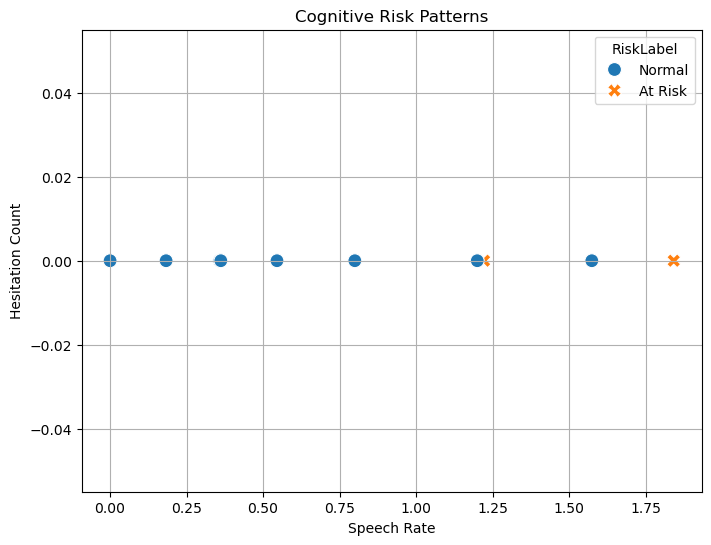

In [36]:
import seaborn as sns

if not df.empty:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="SpeechRate", y="Hesitations", hue="RiskLabel", style="RiskLabel", s=100)
    plt.title("Cognitive Risk Patterns")
    plt.xlabel("Speech Rate")
    plt.ylabel("Hesitation Count")
    plt.grid(True)
    plt.show()


In [38]:
df.to_csv("audio_cognitive_risk_scores.csv", index=False)
print("Saved results to audio_cognitive_risk_scores.csv ✅")


Saved results to audio_cognitive_risk_scores.csv ✅
